# Plot the outcomes of individual test sites

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, SymLogNorm
import itertools as it

rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 14

# soil layer depths in ELM
zsoi = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 2.8646])
zisoi = np.array([0.0175, 0.0451, 0.0906, 0.1655, 0.2891, 0.4929, 0.8289, 1.3828, 2.2961, 3.8019])
dzsoi = np.array([0.0175, 0.0276, 0.0455, 0.0750, 0.1236, 0.2038, 0.3360, 0.5539, 0.9133, 1.5058])

# major cation list
cations = ['Ca2+','Mg2+','Na+','K+','Al3+']

# list of NetCDF file names generated by ELM
date_prefix = '20241010'
region = 'conus'
suffix = 'ICB20TRCNPRDCTCBC_erw'
case_name = f'{date_prefix}_{region}_{suffix}'
start = 2000 # 1985
end = 2010 # 2015
file_list = [
    os.path.join(os.environ['E3SM_ROOT'], 'output',
                 case_name, 'run', f'{case_name}.elm.h1.{year}-01-01-00000.nc')
    for year in range(start, end + 1)
]
tvec = pd.date_range(f'{start}-01-01', f'{end}-12-31', freq = '1D')
tvec = tvec[(tvec.month != 2) & (tvec.month != 29)]

# path to save the graphs
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', f'plot_{region}')
if not os.path.exists(path_out):
    os.mkdir(path_out)

In [2]:
# Plot the domain
hr = xr.open_dataset(
    os.path.join(os.environ['E3SM_ROOT'], 'output', f'{case_name}', 'run', 'surfdata.nc')
)
latixy = hr['LATIXY'].values.reshape(-1)
longxy = hr['LONGXY'].values.reshape(-1)
nsites = len(latixy)
hr.close()

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.LambertConformal()})
ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')
ax.set_extent([-123, -67, 24, 50], crs=ccrs.PlateCarree())
for lat,lon in zip(latixy,longxy):
    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=5)
plt.title('Simulated pixels')
plt.savefig(os.path.join(path_out, 'location_of_pixels.png'), dpi = 600., bbox_inches = 'tight')
plt.close()

# 1. Hydrological balance

In [ ]:
# unit - mm/year
hydro = pd.DataFrame(np.nan, index = np.arange(nsites), 
                     columns = ['P', 'ET', 'QOVER', 'QDRAI'])
vwc = pd.DataFrame(np.nan, columns = np.arange(nsites),
                   index = pd.MultiIndex.from_product([range(1,13),range(1,11)]))
hr = xr.open_mfdataset(file_list)
hydro.loc[:, 'P'] = (hr['RAIN'].values + hr['SNOW'].values).mean(axis = 0) * 86400 * 365
hydro.loc[:, 'ET'] = (hr['QVEGE'].values + hr['QVEGT'].values + hr['QSOIL'].values
                            ).mean(axis = 0) * 86400 * 365
hydro.loc[:, 'QOVER'] = hr['QOVER'].mean(axis = 0).values * 86400 * 365
hydro.loc[:, 'QDRAI'] = hr['QDRAI'].mean(axis = 0).values * 86400 * 365
vwc.loc[:, :] = hr['H2OSOI'].groupby('time.month').mean()[:, :10, :].values.reshape(-1, nsites)
hr.close()

In [ ]:
# Comparison of the annual mean water balance
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex = True, sharey = True, 
                         subplot_kw={'projection': ccrs.LambertConformal()})
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
for i, var in enumerate(['P','ET','QOVER','QDRAI']):
    ax = axes.flat[i]

    # add coastlines and state boundaries
    ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
    ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

    # set colorbar
    pmax = np.floor(hydro[var].max() / 100) * 100
    pmin = np.ceil(hydro[var].min() / 100) * 100
    norm = BoundaryNorm(np.linspace(pmin, pmax, 41), ncolors = 256, extend = 'both')

    cf = ax.scatter(longxy, latixy, c = hydro[var].values, norm = norm, 
                    transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'k')
    ax.set_title(f'{var} (mm/year)')
    # cax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.7, aspect = 20)
plt.savefig(os.path.join(path_out, 'compare_water_balance.png'), dpi = 600., bbox_inches = 'tight')

In [ ]:
vwc_annual = vwc.groupby(level = 1).mean()
vwc_annual

In [ ]:
# Comparison of annual mean soil moisture 
vwc_annual = vwc.groupby(level = 1).mean()

fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex = True, sharey = True, 
                         subplot_kw={'projection': ccrs.LambertConformal()})
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
for i, level in enumerate([1, 3, 6, 10]):
    ax = axes.flat[i]

    # add coastlines and state boundaries
    ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
    ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

    # set colorbar
    ##pmax = np.floor(vwc_annual.loc[level, :].max() * 100) / 100
    ##pmin = np.ceil(vwc_annual.loc[level, :].min() * 100) / 100
    norm = BoundaryNorm(np.linspace(0.1, 0.45, 41), ncolors = 256, extend = 'both')

    cf = ax.scatter(longxy, latixy, c = vwc_annual.loc[level, :].values, norm = norm, 
                    transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'k')
    ax.set_title(f'Layer {level} (mm3 mm-3)')
    # cax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.7, aspect = 20)
fig.suptitle('Comparison of monthly soil moisture at the sites', fontsize = 14)
plt.savefig(os.path.join(path_out, 'compare_vwc.png'), dpi = 600., bbox_inches = 'tight')

# 2. Cation balance

## 2.1 Target variable: `r_sequestration`

Direct subtraction of background weathering rate is not good practice.

Need to subtract from just control run.

In [ ]:
r_sequestration = pd.DataFrame(np.nan, columns = np.arange(nsites), index = range(start, end))
hr = xr.open_mfdataset(file_list)
r_sequestration.loc[:, :] = hr['r_sequestration'].resample(time = '1Y').mean().values  \
    * 86400 * 365 / 100
hr.close()

In [ ]:
r_sequestration = r_sequestration.loc[2001:2010,:].mean(axis = 0)

fig, ax = plt.subplots(figsize=(10, 5), sharex = True, sharey = True, 
                       subplot_kw={'projection': ccrs.LambertConformal()})
# add coastlines and state boundaries
ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')
# set colorbar
norm = SymLogNorm(vmin = -0.02, vmax = 0.02, linthresh = 1e-4)

cf = ax.scatter(longxy, latixy, c = r_sequestration.values, norm = norm, 
                transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'k')
plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.7, aspect = 20)
ax.set_title('r_sequestration  (ton ha-1 year-1) 2001-2010 including ' + 
             'background weathering and rock addition', fontsize = 14)
plt.savefig(os.path.join(path_out, 'compare_r_sequestration.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

## 2.2 Primary mineral dissolution

Integrated over all the layers (primary mineral only exists until mixing depth - the top six layers)

In [ ]:
minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
minerals_mass = [116.159, 140.6931,  262.22, 278.21, 483.22, 
                 100.0872, 271.937, 236.371, 278.35, 100.4] # g mol-1
# normal alkali basalt (fast)
# pct_basalt = np.array([0, 12, 0, 0, 0, 0, 43, 21, 6, 0])

# ! Need to correct: the other three are not saved! 
mineral_list = [2, 7, 8, 9]

In [ ]:
# g Rock m-2 => ton ha-1
# Resample using "max()" to get the start value in each year
primary_mineral = pd.DataFrame(np.nan, index = range(start, end+1),
    columns = pd.MultiIndex.from_product([mineral_list, np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for min in mineral_list:
    temp = hr[f'primary_mineral_vr_{min}'][hr['time'].to_index().year >= 1999, :10, 
                                           :].resample(time = '1Y').max().values/100
    temp = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1)
    primary_mineral.loc[:, min] = temp
hr.close()

# mol m-3 s-1 => ton ha-1 year-1
# Resample using "max()" since this is mainly controlled by primary mineral mass
r_dissolve = pd.DataFrame(np.nan, index = range(start, end + 1),
    columns = pd.MultiIndex.from_product([mineral_list, np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for min in mineral_list:
    temp = hr[f'r_dissolve_vr_{min}'][hr['time'].to_index().year >= 1999, :10, 
                                      :].resample(time = '1Y').max().values
    temp = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1)
    temp = temp / 100 * 365 * 86400 * minerals_mass[min-1]
    r_dissolve.loc[:, min] = temp
hr.close()

In [ ]:
# Percentage mineral in year 2000 (time of application), 2001 (3 month after application), 
# 2002 (2 years), 2005 (5 years), 2010 (10 years)
for data_var, filename, unit in zip([primary_mineral, r_dissolve], 
                                   ['primary_mineral_state', 'mineral_dissolve_rate'], 
                                   ['ton ha-1', 'ton ha-1 year-1']):
    data_var = data_var.loc[[2000, 2001, 2002, 2005, 2010], :]
    fig, axes = plt.subplots(5, 4, figsize = (20, 12), sharex = True, sharey = True, 
                            subplot_kw={'projection': ccrs.LambertConformal()})
    for i, year in enumerate([2000, 2001, 2002, 2005, 2010]):
        for j, min in enumerate(mineral_list):
            ax = axes[i,j]

            # add coastlines and state boundaries
            ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
            ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

            # set colorbar
            pmax = data_var.loc[:, min].max().max()
            pmin = data_var.loc[:, min].min().min()
            # round to 2 decimal point in scientific notation
            pmax = float(f'{pmax:.2E}')
            pmin = float(f'{pmin:.2E}')
            if (pmax-pmin) < 1e-12: # set a tiny value
                pmax = pmin + 1e-12

            norm = BoundaryNorm(np.linspace(pmin, pmax, 41), ncolors = 256, extend = 'both')
            cf = ax.scatter(longxy, latixy, c = data_var.loc[year, min], norm = norm, s = 2,
                            transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'none')
            if i == 0:
                ax.set_title(minerals_name[min-1])
            if j == 0:
                ax.text(-0.1, 0.5, year, rotation = 90, verticalalignment = 'center', 
                        transform = ax.transAxes)
            plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.9, aspect = 20)
    if filename == 'primary_mineral_state':
        fig.suptitle(f'Remaining primary mineral ({unit})', fontsize = 14)
    else:
        fig.suptitle(f'Primary mineral dissolution rate ({unit})', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_{filename}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

## 2.3. Cation states: pH, cation concentration, CEC H+ and cations

Integrate to two levels: mixing depth and all soil layers

In [ ]:
# soil pH in year 2000 (time of application), 2001 (3 month after application), 
# 2002 (2 years), 2005 (5 years), 2010 (10 years)
soil_pH = pd.DataFrame(np.nan, index = range(start, end),
    columns = pd.MultiIndex.from_product([['mixing_depth','full_depth'], np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
temp = hr['soil_pH'][:, :10, :].resample(time = '1Y').mean().values
temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
soil_pH.loc[:, 'full_depth'] = temp1
temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
soil_pH.loc[:, 'mixing_depth'] = temp2
hr.close()

In [ ]:
# cation concentration in soil solution, g m-3
soil_cation = pd.DataFrame(np.nan, index = range(start, end),
    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'], 
                                          np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for i in range(len(cations)):
    temp = hr[f'cation_vr_{i+1}'][:, :10, :].resample(time = '1Y').mean().values

    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
    soil_cation.loc[:, (cations[i],'full_depth')] = temp1

    temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
    soil_cation.loc[:, (cations[i],'mixing_depth')] = temp2
hr.close()

In [ ]:
# CEC H+, g m-3 // need bulk density to convert to meq 100g-1 soil, forgot to save
cec_proton = pd.DataFrame(np.nan, index = range(1985, 2015),
    columns = pd.MultiIndex.from_product([['mixing_depth','full_depth'], np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
temp = hr['cec_proton_vr'][:, :10, :].resample(time = '1Y').mean().values
temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
cec_proton.loc[:, 'full_depth'] = temp1
temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
cec_proton.loc[:, 'mixing_depth'] = temp2
hr.close()

In [ ]:
# CEC cations, g m-3 // need bulk density to convert to meq 100g-1 soil, forgot to save
cec_cation = pd.DataFrame(np.nan, index = range(1985, 2015),
    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'], 
                                          np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for i in range(len(cations)):
    temp = hr[f'cec_cation_vr_{i+1}'][:, :10, :].resample(time = '1Y').mean().values
    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
    cec_cation.loc[:, (cations[i],'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
    cec_cation.loc[:, (cations[i],'mixing_depth')] = temp2
hr.close()

In [ ]:
# Soil pH and CEC H+ in 2001 (3 month after application), 2002 (2 years), 2005 (5 years), 
# 2010 (10 years), all relative to the year 2000 (time of application) baseline
for data_var, data_name, data_unit, file_name in zip([soil_pH, cec_proton],
    ['soil pH', 'CEC H+'], ['', 'g m-3'], ['soil_ph', 'cec_proton']):
    data_var = data_var.loc[[2001, 2002, 2005, 2010], :] - data_var.loc[2000, :]

    fig, axes = plt.subplots(4, 2, figsize = (10, 8), sharex = True, sharey = True, 
                             subplot_kw={'projection': ccrs.LambertConformal()})
    for i, year in enumerate([2001, 2002, 2005, 2010]):
        for j, depth in enumerate(['mixing_depth', 'full_depth']):
            ax = axes[i,j]

            # add coastlines and state boundaries
            ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
            ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

            # set colorbar
            pmax = data_var.loc[:, depth].max().max()
            pmin = data_var.loc[:, depth].min().min()
            p = max(abs(pmax), abs(pmin))
            norm = BoundaryNorm(np.linspace(-p, p, 41), ncolors = 256, extend = 'both')
            cf = ax.scatter(longxy, latixy, c = data_var.loc[year, depth], norm = norm, 
                            transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'k')
            if i == 0:
                ax.set_title(depth)
            if j == 0:
                ax.text(-0.1, 0.5, '$\Delta$ '+f'{year}', rotation = 90, 
                        verticalalignment = 'center', transform = ax.transAxes)
            plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 1, aspect = 20)
    fig.suptitle(f'{data_name} {data_unit}', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_{file_name}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

In [ ]:
for icat,ion in enumerate(cations):
    for data_var, data_name, data_unit, file_name in zip([soil_cation, cec_cation],
        [f'soil {ion}', f'CEC {ion}'], ['g m-3', 'g m-3'], [f'soil_{icat}', f'cec_{icat}']):
        data_var = data_var.loc[[2001, 2002, 2005, 2010], ion] - data_var.loc[2000, ion]

        fig, axes = plt.subplots(4, 2, figsize = (10, 8), sharex = True, sharey = True, 
                                subplot_kw={'projection': ccrs.LambertConformal()})
        for i, year in enumerate([2001, 2002, 2005, 2010]):
            for j, depth in enumerate(['mixing_depth', 'full_depth']):
                ax = axes[i,j]

                # add coastlines and state boundaries
                ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
                ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

                # set colorbar
                pmax = data_var.loc[:, depth].max().max()
                pmin = data_var.loc[:, depth].min().min()
                p = max(abs(pmax), abs(pmin))
                norm = BoundaryNorm(np.linspace(-p, p, 41), ncolors = 256, extend = 'both')
                cf = ax.scatter(longxy, latixy, c = data_var.loc[year, depth], norm = norm, 
                                transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'k')
                if i == 0:
                    ax.set_title(depth)
                if j == 0:
                    ax.text(-0.1, 0.5, '$\Delta$ '+f'{year}', rotation = 90, 
                            verticalalignment = 'center', transform = ax.transAxes)
                plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 1, aspect = 20)
        fig.suptitle(f'{data_name} {data_unit}', fontsize = 14)
        plt.savefig(os.path.join(path_out, f'compare_{file_name}.png'), 
                    dpi = 600., bbox_inches = 'tight')
        #plt.close()

## 2.4 Cation dynamics

All variables are converted to + := adding to solution, - := removing from solution

 background weathering
 
 primary cation flux
  
 (-1) * secondary cation flux (so that positive values = adding to solution)
 
 CEC cation flux (positive values = adding to solution)

 ~~cation_infl_vr~~ this should only look at layer 0
 
 cation_leached_vr
 
 cation_runoff_vr

In [ ]:
for data_name, data_unit, file_name in zip(
    ['background_weathering_vr', 'primary_cation_flux_vr', 'secondary_cation_flux_vr',
     'cec_cation_flux_vr', 'cation_leached_vr', 'cation_runoff_vr'], 
    ['g m-3 year-1', 'g m-3 year-1', 'g m-3 day-1', 
     'g m-3 day-1', 'g m-3 day-1', 'g m-3 day-1'],
    ['background_weathering_vr', 'primary_cation_flux_vr', 'secondary_cation_flux_vr',
     'cec_cation_flux_vr', 'cation_leached_vr', 'cation_runoff_vr'] 
):
    for icat,ion in enumerate(cations):
        data_var = pd.DataFrame(np.nan, index = range(start, end + 1),
            columns = pd.MultiIndex.from_product([['mixing_depth', 'full_depth'], 
                                                  np.arange(nsites)]))
        hr = xr.open_mfdataset(file_list)
        temp = hr[f'{data_name}_{icat+1}'][:, :10, :].resample(time = '1Y').mean().values
        temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
        data_var.loc[:, 'full_depth'] = temp1 * 86400 * 365
        temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
        data_var.loc[:, 'mixing_depth'] = temp2 * 86400 * 365
        hr.close()

        data_var = data_var.loc[[2000, 2001, 2002, 2005, 2010], :]

        if data_name in ['secondary_cation_flux_vr', 'cation_leached_vr', 'cation_runoff_vr']:
            data_var = - data_var

        if np.abs(data_var.max().max() - data_var.min().min()) < 1e-12:
            continue

        fig, axes = plt.subplots(5, 2, figsize = (10, 10), sharex = True, sharey = True, 
                                subplot_kw={'projection': ccrs.LambertConformal()})
        for i, year in enumerate([2000, 2001, 2002, 2005, 2010]):
            for j, depth in enumerate(['mixing_depth', 'full_depth']):
                ax = axes[i,j]

                # add coastlines and state boundaries
                ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
                ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

                # set colorbar
                pmax = data_var.loc[:, depth].max().max()
                pmin = data_var.loc[:, depth].min().min()
                # round to 2 scientific digits
                pmax = float(f'{pmax:.2e}')
                pmin = float(f'{pmin:.2e}')
                p = max(abs(pmax), abs(pmin))
                # norm = BoundaryNorm(np.linspace(-p, p, 41), ncolors = 256, extend = 'both')
                norm = SymLogNorm(linthresh = p / 1000, vmax = p, vmin = -p, clip = False)
                cf = ax.scatter(longxy, latixy, c = data_var.loc[year, depth], norm = norm, 
                                transform = ccrs.PlateCarree(), cmap = 'Spectral', edgecolor = 'k')
                if i == 0:
                    ax.set_title(depth)
                if j == 0:
                    ax.text(-0.1, 0.5, f'{year}', rotation = 90, 
                            verticalalignment = 'center', transform = ax.transAxes)
                plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 1, aspect = 20)
        fig.suptitle(f'{data_name} {ion} {data_unit}', fontsize = 14)
        plt.savefig(os.path.join(path_out, f'compare_{file_name}_{icat+1}.png'), 
                    dpi = 600., bbox_inches = 'tight')
        #plt.close()

## 2.5 Secondary mineral formation

Integrate to two levels: mixing depth and all soil layers

In [3]:
minsecs_name = ['Calcite', 'Kaolinite']
minsecs_list = [1,2]
minsecs_mass = [100.0872, 258.1604]

In [4]:
# g mineral m-2
# Resample using "mean()" to get the average value in each year
secondary_mineral = pd.DataFrame(np.nan, index = range(start, end + 1),
    columns = pd.MultiIndex.from_product([minsecs_list, ['mixing_depth', 'full_depth'], 
                                          np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for min in minsecs_list:
    temp = hr[f'secondary_mineral_vr_{min}'][hr['time'].to_index().year >= 1999, :10, 
                                           :].resample(time = '1Y').mean().values
    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1)
    secondary_mineral.loc[:, (min, 'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), axis = 1)
    secondary_mineral.loc[:, (min, 'mixing_depth')] = temp2
hr.close()

# mol m-3 s-1 => g m-2 year-1
# Resample using "mean()" to get the average value in each year
r_precip = pd.DataFrame(np.nan, index = range(start, end + 1),
    columns = pd.MultiIndex.from_product([minsecs_list, ['mixing_depth', 'full_depth'], 
                                          np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for min in minsecs_list:
    temp = hr[f'r_precip_vr_{min}'][hr['time'].to_index().year >= 1999, :10, 
                                    :].resample(time = '1Y').mean().values
    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) * 365 * 86400 * minsecs_mass[min-1]
    r_precip.loc[:, (min,'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), 
                   axis = 1) * 365 * 86400 * minsecs_mass[min-1]
    r_precip.loc[:, (min,'mixing_depth')] = temp2
hr.close()

/tmp/ipykernel_2694280/1521658490.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  secondary_mineral.loc[:, (min, 'full_depth')] = temp1
/tmp/ipykernel_2694280/1521658490.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  secondary_mineral.loc[:, (min, 'mixing_depth')] = temp2
/tmp/ipykernel_2694280/1521658490.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  secondary_mineral.loc[:, (min, 'full_depth')] = temp1
/tmp/ipykernel_2694280/1521658490.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  secondary_mineral.loc[:, (min, 'mixing_depth')] = temp2
/tmp/ipykernel_2694280/1521658490.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  r_precip.loc[:, (min,'full_depth')] = temp1
/tmp/ipykernel_2694280/1521658490.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  r_precip.loc[:, (min,'mixing_depth')] = temp2


/tmp/ipykernel_2694280/458406074.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmax = data_var.loc[:, (min, depth)].max().max()
/tmp/ipykernel_2694280/458406074.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmin = data_var.loc[:, (min, depth)].min().min()
/tmp/ipykernel_2694280/458406074.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  cf = ax.scatter(longxy, latixy, c = data_var.loc[year, (min, depth)], norm = norm,
/tmp/ipykernel_2694280/458406074.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmax = data_var.loc[:, (min, depth)].max().max()
/tmp/ipykernel_2694280/458406074.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmin = data_var.loc[:, (min, depth)].min().min()
/tmp/ipykernel_2694280/458406074.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  cf = ax.scatter(longxy, latixy, c = d

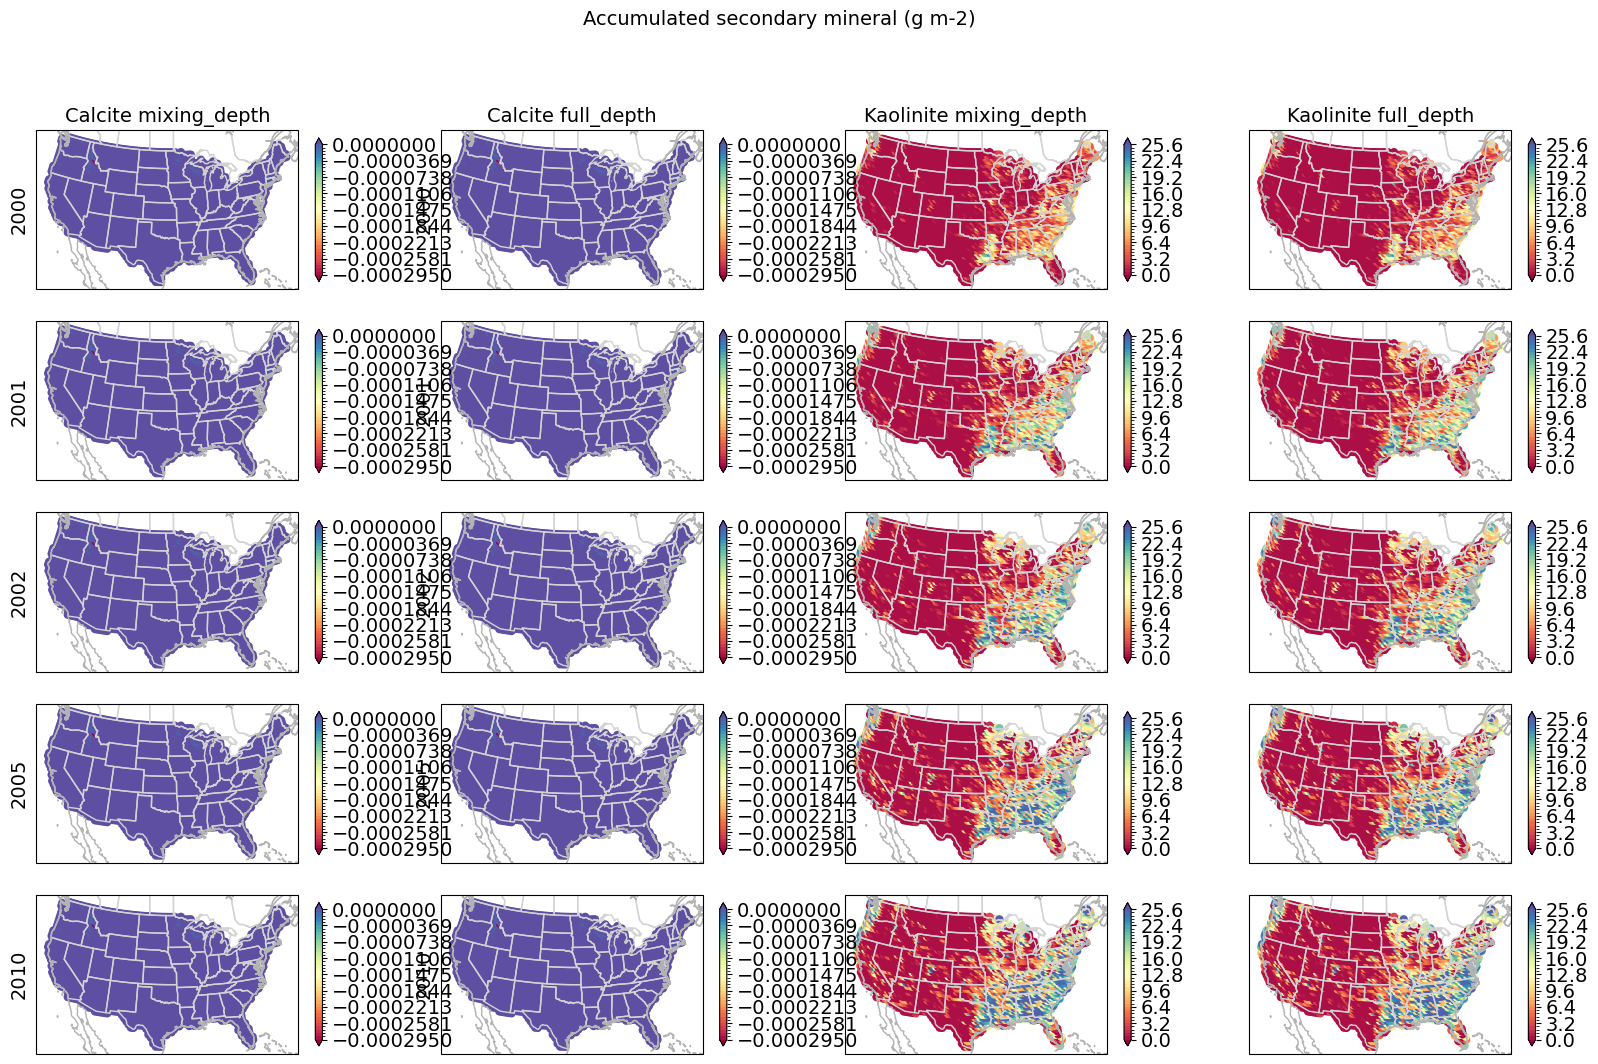

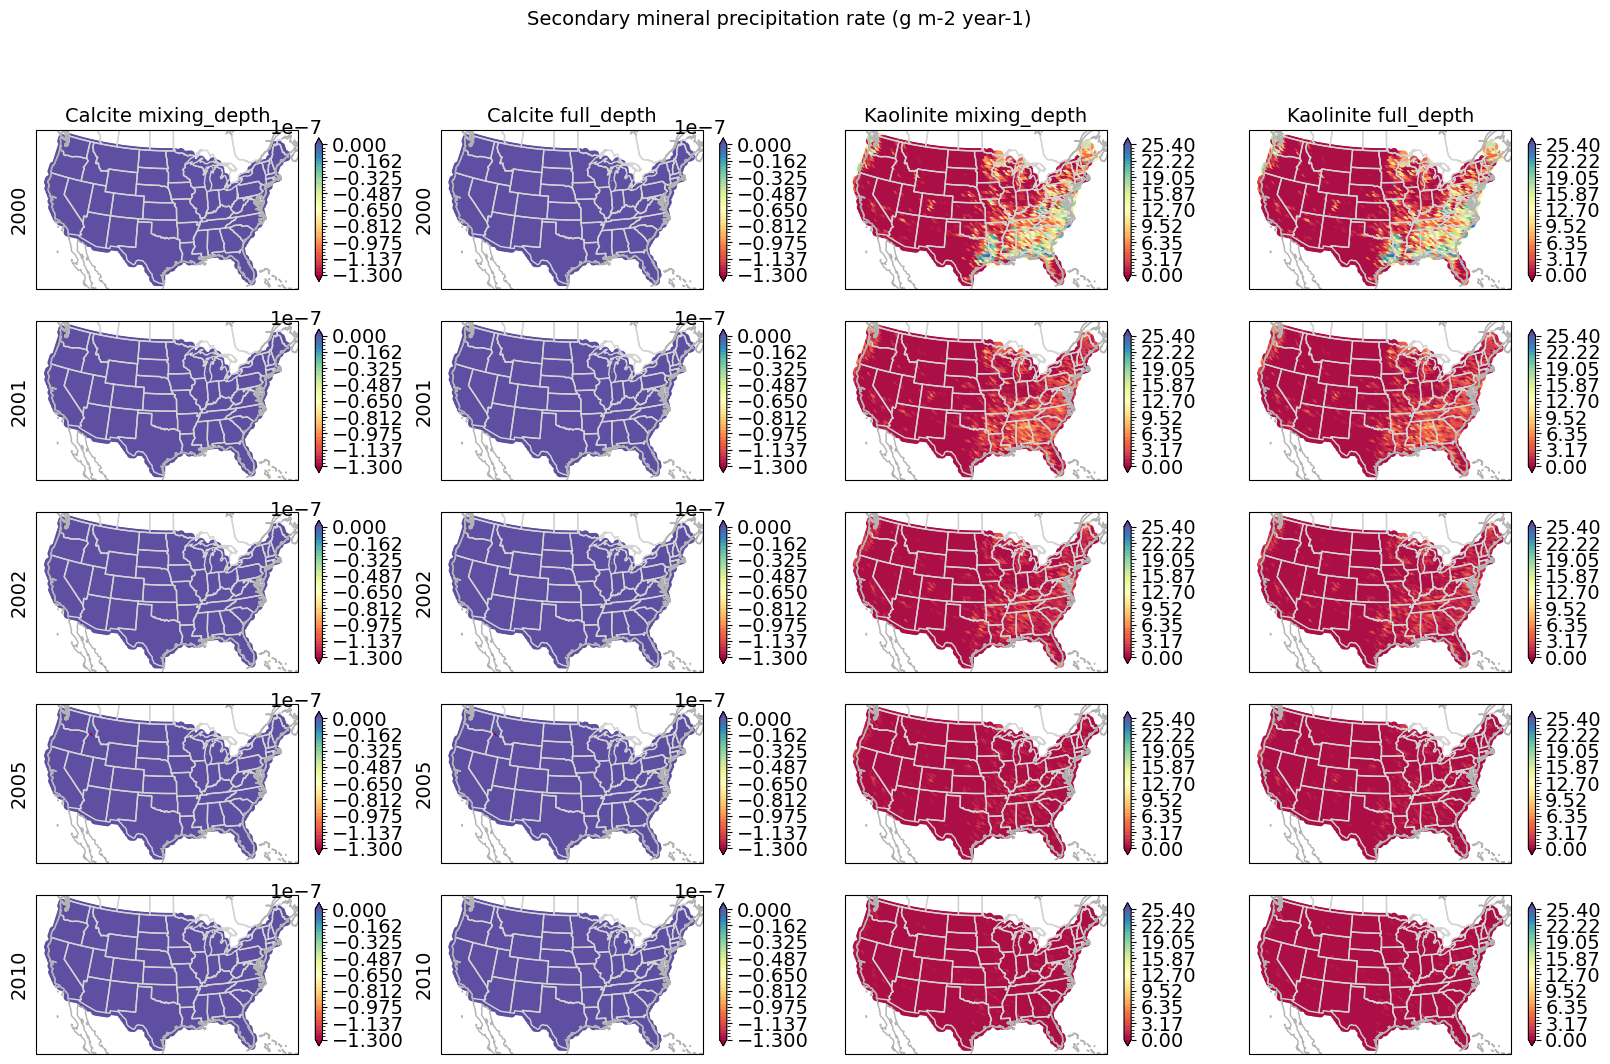

In [6]:
# Percentage mineral in year 2000 (time of application), 2001 (3 month after application), 
# 2002 (2 years), 2005 (5 years), 2010 (10 years)
for data_var, filename, unit in zip([secondary_mineral, r_precip], 
                                   ['secondary_mineral_state', 'secondary_mineral_precip'], 
                                   ['g m-2', 'g m-2 year-1']):
    data_var = data_var.loc[[2000, 2001, 2002, 2005, 2010], :]
    fig, axes = plt.subplots(5, 4, figsize = (20, 12), sharex = True, sharey = True, 
                            subplot_kw={'projection': ccrs.LambertConformal()})
    for i, year in enumerate([2000, 2001, 2002, 2005, 2010]):
        for j, min in enumerate(minsecs_list):
            for k, depth in enumerate(['mixing_depth', 'full_depth']):
                ax = axes[i,j*2 + k]

                # add coastlines and state boundaries
                ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
                ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

                # set colorbar
                pmax = data_var.loc[:, (min, depth)].max().max()
                pmin = data_var.loc[:, (min, depth)].min().min()
                # round to 2 decimal point in scientific notation
                pmax = float(f'{pmax:.2E}')
                pmin = float(f'{pmin:.2E}')
                if (pmax-pmin) < 1e-12: # set a tiny value
                    pmax = pmin + 1e-12

                norm = BoundaryNorm(np.linspace(pmin, pmax, 41), ncolors = 256, extend = 'both')
                cf = ax.scatter(longxy, latixy, c = data_var.loc[year, (min, depth)], norm = norm, 
                                transform = ccrs.PlateCarree(), cmap = 'Spectral',
                                edgecolor = 'none')
                if i == 0:
                    ax.set_title(f'{minsecs_name[min-1]} {depth}')
                if j == 0:
                    ax.text(-0.1, 0.5, year, rotation = 90, verticalalignment = 'center', 
                            transform = ax.transAxes)
                plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.9, aspect = 20)
    if filename == 'secondary_mineral_state':
        fig.suptitle(f'Accumulated secondary mineral ({unit})', fontsize = 14)
    else:
        fig.suptitle(f'Secondary mineral precipitation rate ({unit})', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_{filename}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

## 2.6 Leaching loss

In [13]:
# g m-3 s-1 => g m-2 year-1
# Resample using "mean()" to get the average value in each year
leaching = pd.DataFrame(np.nan, index = range(start, end + 1),
    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'], 
                                          np.arange(nsites)]))
hr = xr.open_mfdataset(file_list)
for cat, cation in enumerate(cations):
    temp = hr[f'cation_leached_vr_{cat+1}'][hr['time'].to_index().year >= 1999, :10, 
                                          :].resample(time = '1Y').mean().values
    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) * 365 * 86400
    leaching.loc[:, (cation,'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6, :] * dzsoi[:6].reshape(1, -1, 1), 
                   axis = 1) * 365 * 86400
    leaching.loc[:, (cation,'mixing_depth')] = temp2
hr.close()

/tmp/ipykernel_2694280/3116811550.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaching.loc[:, (cation,'full_depth')] = temp1
/tmp/ipykernel_2694280/3116811550.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaching.loc[:, (cation,'mixing_depth')] = temp2
/tmp/ipykernel_2694280/3116811550.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaching.loc[:, (cation,'full_depth')] = temp1
/tmp/ipykernel_2694280/3116811550.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaching.loc[:, (cation,'mixing_depth')] = temp2
/tmp/ipykernel_2694280/3116811550.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaching.loc[:, (cation,'full_depth')] = temp1
/tmp/ipykernel_2694280/3116811550.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  leaching.loc[:, (cation,'mixing_depth')] = temp2
/tmp/ipykernel_2694280

/tmp/ipykernel_2694280/893213689.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmax = data_var.loc[:, (cation, depth)].max().max()
/tmp/ipykernel_2694280/893213689.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmin = data_var.loc[:, (cation, depth)].min().min()
/tmp/ipykernel_2694280/893213689.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  cf = ax.scatter(longxy, latixy, c = data_var.loc[year, (cation, depth)], norm = norm,
/tmp/ipykernel_2694280/893213689.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmax = data_var.loc[:, (cation, depth)].max().max()
/tmp/ipykernel_2694280/893213689.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmin = data_var.loc[:, (cation, depth)].min().min()
/tmp/ipykernel_2694280/893213689.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  cf = ax.scatter(longxy

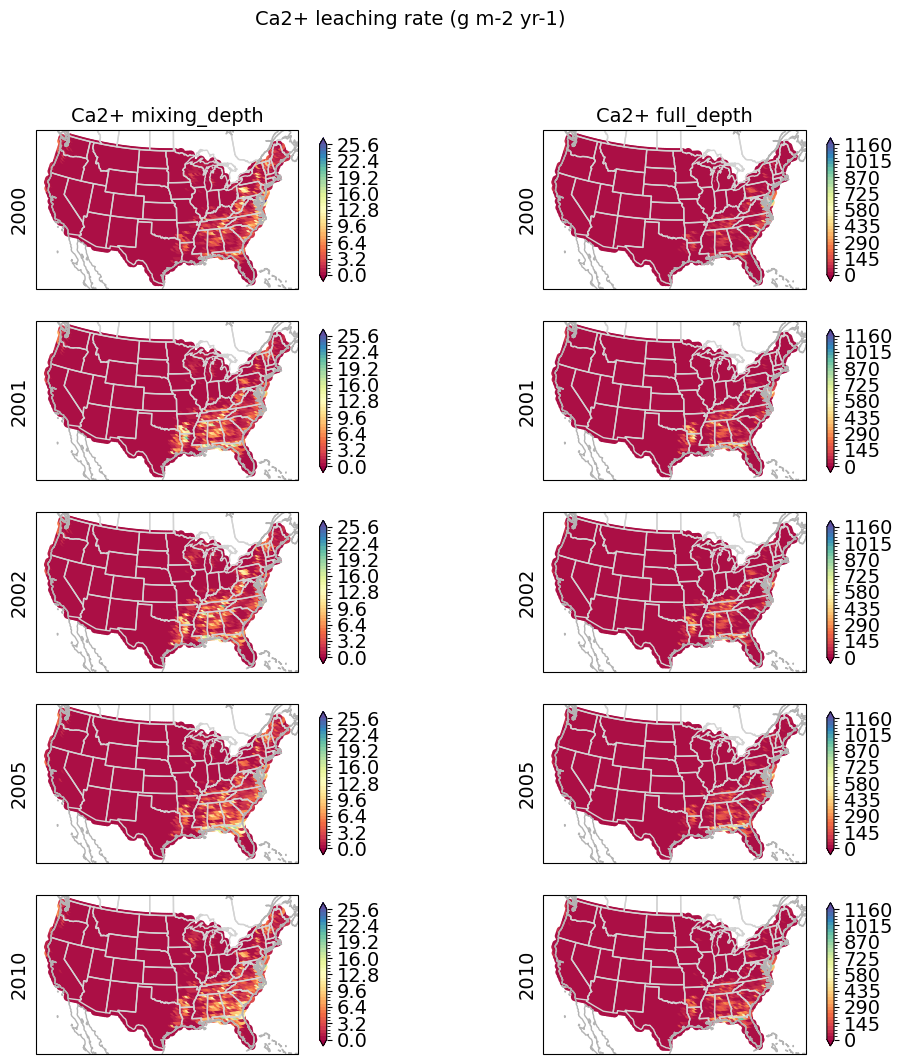

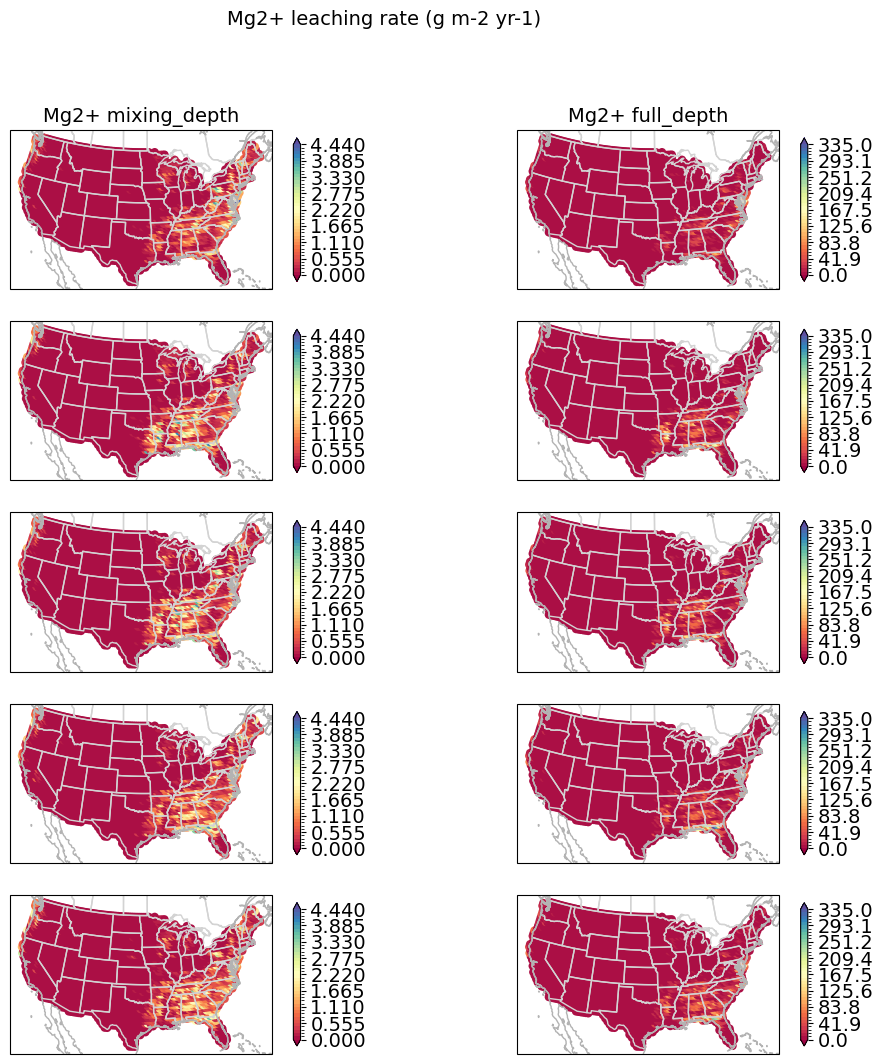

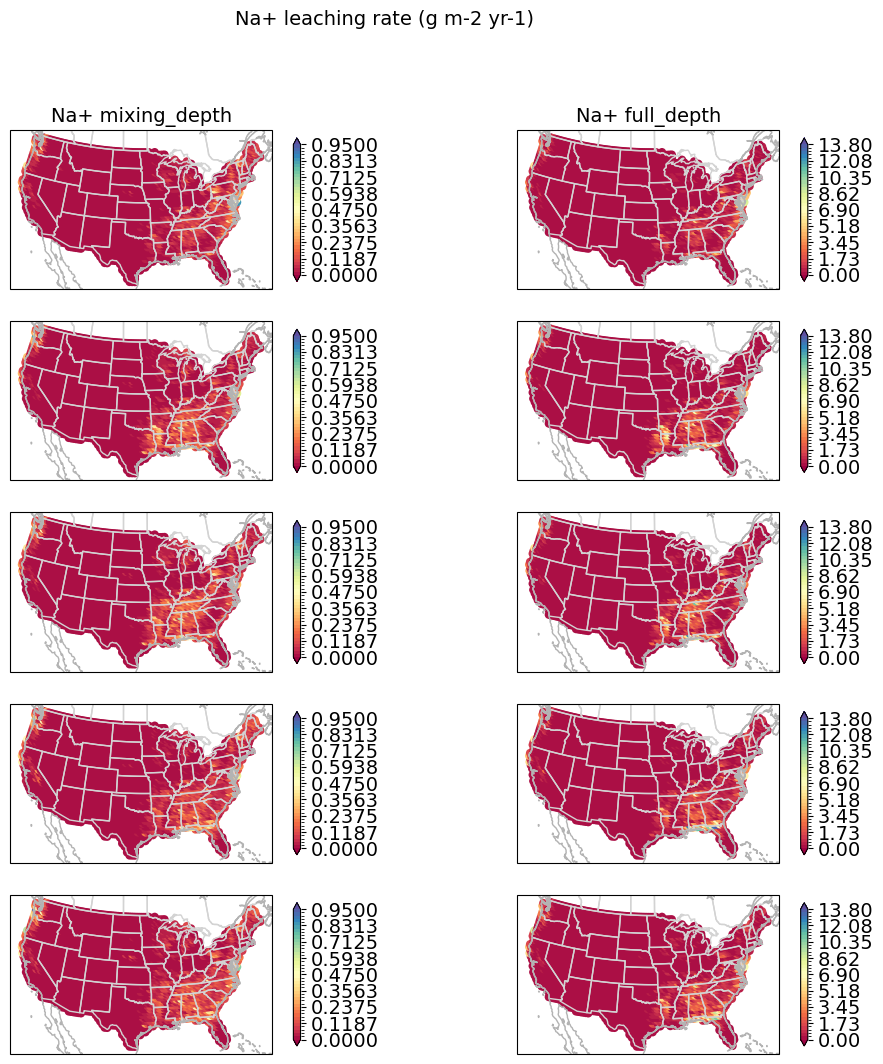

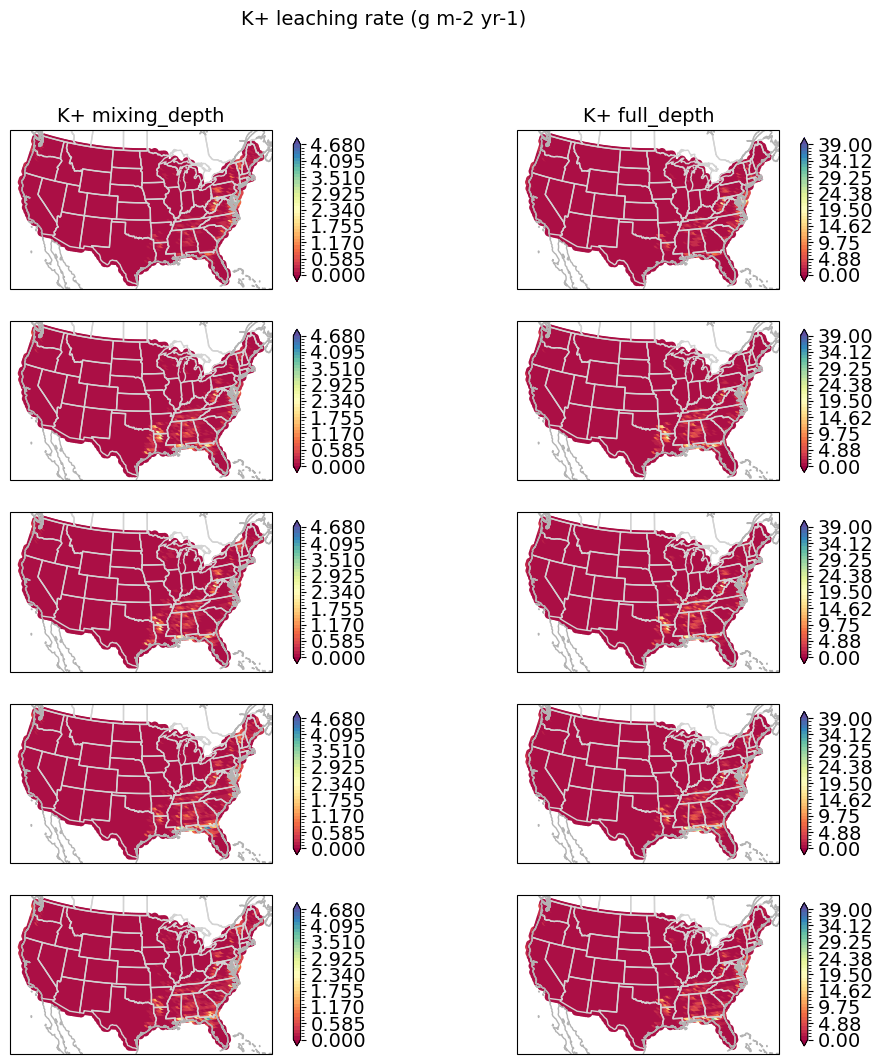

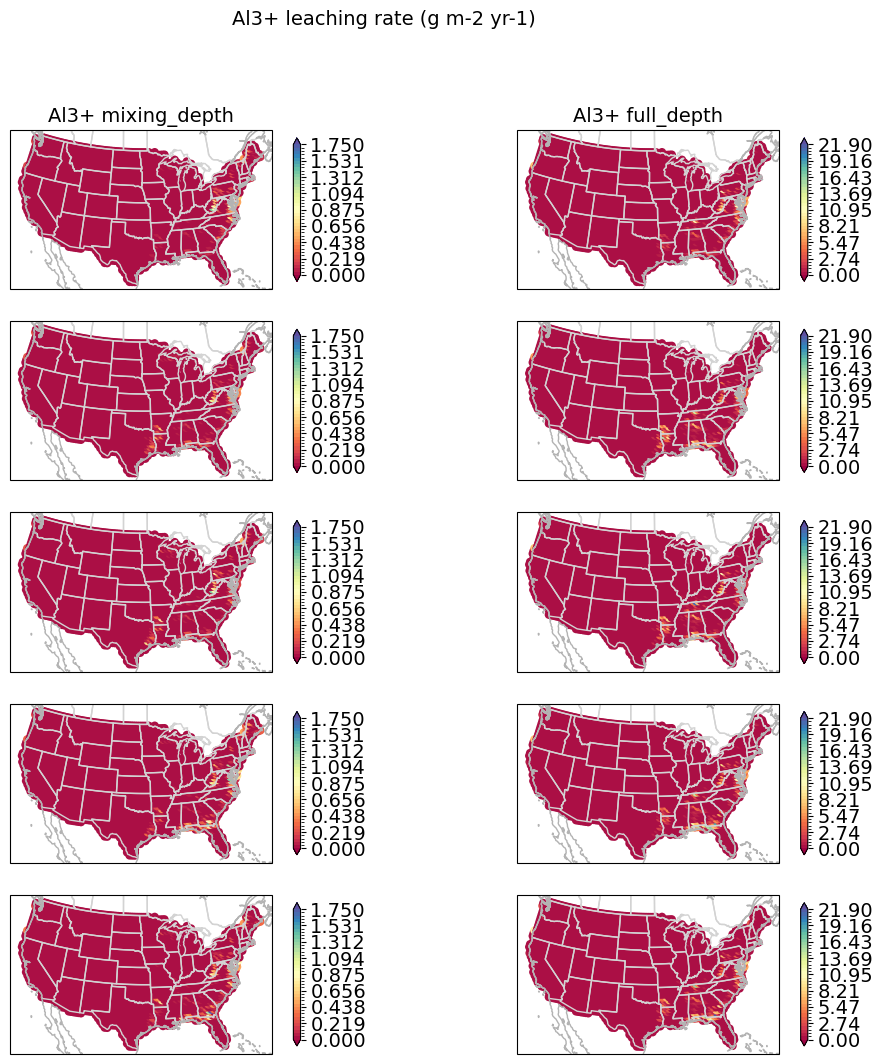

In [16]:
data_var = leaching.loc[[2000, 2001, 2002, 2005, 2010], :]
for j, cation in enumerate(cations):
    fig, axes = plt.subplots(5, 2, figsize = (12, 12), sharex = True, sharey = True, 
                            subplot_kw={'projection': ccrs.LambertConformal()})
    for i, year in enumerate([2000, 2001, 2002, 2005, 2010]):
        for k, depth in enumerate(['mixing_depth', 'full_depth']):
            ax = axes[i,k]

            # add coastlines and state boundaries
            ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
            ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')

            # set colorbar
            pmax = data_var.loc[:, (cation, depth)].max().max()
            pmin = data_var.loc[:, (cation, depth)].min().min()
            # round to 2 decimal point in scientific notation
            pmax = float(f'{pmax:.2E}')
            pmin = float(f'{pmin:.2E}')
            if (pmax-pmin) < 1e-12: # set a tiny value
                pmax = pmin + 1e-12

            norm = BoundaryNorm(np.linspace(pmin, pmax, 41), ncolors = 256, extend = 'both')
            cf = ax.scatter(longxy, latixy, c = data_var.loc[year, (cation, depth)], norm = norm, 
                            transform = ccrs.PlateCarree(), cmap = 'Spectral',
                            edgecolor = 'none')
            if i == 0:
                ax.set_title(f'{cation} {depth}')
            if j == 0:
                ax.text(-0.1, 0.5, year, rotation = 90, verticalalignment = 'center', 
                        transform = ax.transAxes)
            plt.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.9, aspect = 20)
    fig.suptitle(f'{cation} leaching rate (g m-2 yr-1)', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_cation_leaching_{cation}.png'), 
                dpi = 600., bbox_inches = 'tight')

In [9]:
leaching

1                                               ...  \
     mixing_depth                                               ...   
             0    1    2    3    4    5    6    7    8    9     ...   
2000          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2001          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2003          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2004          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2005          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2006          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2007          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2008          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2009          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2010          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

              2                                                            \
     full_depth                                                             
           3280          3281          3282      3283      3284      3285   
2000   0.000160  3.543260e-08  2.563734e-09  0.000005  0.000004  0.000029   
2001   0.000221  4.641243e-08  1.516611e-09  0.000005  0.000002  0.000035   
2002   0.000214  4.815270e-08  1.403805e-09  0.000005  0.000002  0.000038   
2003   0.000151  3.471965e-08  1.236115e-09  0.000004  0.000001  0.000026   
2004   0.000161  3.743617e-08  1.239482e-09  0.000003  0.000001  0.000019   
2005   0.000304  1.544591e-07  4.522431e-09  0.000006  0.000002  0.000039   
2006   0.000344  3.342701e-07  1.169528e-08  0.000010  0.000003  0.000039   
2007   0.000241  2.401803e-07  1.263285e-08  0.000010  0.000002  0.000021   
2008   0.000160  2.177857e-07  1.373028e-08  0.000010  0.000002  0.000017   
2009   0.000207  5.313224e-07  2.600234e-08  0.000013  0.000002  0.000027   
2010   0.000297  1.521017e-06  5.881992e-08  0.000014  0.000003  0.000036   

                                              
                                              
          3286      3287      3288      3289  
2000  0.000024  0.000766  0.001533  0.044261  
2001  0.000011  0.001083  0.002241  0.057790  
2002  0.000008  0.000946  0.001736  0.042192  
2003  0.000004  0.000371  0.000740  0.017947  
2004  0.000003  0.000779  0.001161  0.043150  
2005  0.000006  0.001090  0.002058  0.046848  
2006  0.000006  0.000698  0.001481  0.029134  
2007  0.000003  0.000426  0.000734  0.037204  
2008  0.000002  0.000597  0.001171  0.043124  
2009  0.000003  0.000813  0.001406  0.035511  
2010  0.000005  0.001161  0.002169  0.050224  

[11 rows x 13160 columns]